In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
from cloudpickle import dumps
from  mlrun.mlutils import (get_sample, get_splits,
                            create_class, gen_sklearn_model,
                            eval_class_model)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact

In [5]:
def train_model(
    context: MLClientCtx,
    model_pkg_class: str,
    dataset: DataItem,
    label_column: str = "labels",
    sample: int = -1,
    test_size: float = 0.05,
    valid_size: float = 0.75,
    random_state: int = 1,
    model_filename: str = "model",
    models_dest: str = "models",
    plots_dest: str = "plots",
    score_method: str = "micro",
    file_ext: str = "parquet",
) -> None:
    """train a classifier.

    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or model config json file
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param model_filename:    model file filename,
                              points to a directory
    :param test_size:         (0.05) test set size
    :param valid_size:   (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param rng:               (1) sklearn rng seed
    :param models_dest:       models subfolder on artifact path
    :param cmap:              matplotlib `Colormap`
    :param plots_dest:        plot subfolder on artifact path
    :param score_method:      for multiclass classification
    
    :param file_ext:          format for test_set_key hold out data
    """
    models_dest = models_dest or 'models'
    plots_dest = plots_dest or f'plots/{context.name}'
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain,ytrain), (xvalid,yvalid), \
    (xtest,ytest), (xcal, ycal) = get_splits(
        raw, labels, 4,
        test_size, 
        valid_size, 
        ["labels"],
        random_state)

    # generate an sklearn model
    model_config = gen_sklearn_model(model_pkg_class, context.parameters.items())
    model_short_name = model_config["META"]["class"].split('.')[-1]
    
    # instantiate the model
    SklearnClass = create_class(model_config["META"]["class"])
    model = SklearnClass(**model_config["CLASS"])

    # update parameters
    model_config["FIT"].update({"X": xtrain,"y": ytrain.values})
  
    # fit
    model.fit(**model_config["FIT"])
 
    # evaluate model
    eval_metrics = eval_class_model(xvalid, yvalid, model)
        
    # log model
    model_plots = eval_metrics.pop("plots")
    # just do this inside log_model?
    for plot in model_plots:
        context.log_artifact(plot, local_path=f'{plots_dest}/{plot.key}.html')

    model_bin = dumps(model)
    context.log_model(model_short_name, body=model_bin, 
                      model_dir="models", 
                      model_file='sklearn-model.pkl',
                      metrics=eval_metrics)

    context.log_results(eval_metrics)

In [6]:
# nuclio: end-code

### mlconfig

In [7]:
from mlrun import mlconf
import os
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["V3IO_HOME"]}/artifacts'

### save

In [8]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("sklearn_classifier")

# add metadata (for templates and reuse)
fn.spec.default_handler = "train_model"
fn.spec.description = "train any classifier using scikit-learn's API"
fn.metadata.categories = ["ml", "training"]
fn.metadata.labels = {"author": "yjb", "framework": "sklearn"}

fn.export("function.yaml")

[mlrun] 2020-05-03 15:51:53,938 function spec saved to path: function.yaml


## tests

In [9]:
if "V3IO_HOME" in list(os.environ):
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # is you set up mlrun using the instructions at 
    # https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc('nfsvol', 'nfsvol', '/home/joyan/data'))

In [10]:
from mlrun import NewTask    

task_params = {
    "name" : "",
    "params" : {
        # CHOOSE YOUR MODEL AND CHANGE SOME DEFAULT PARAMETERS
       # "model_pkg_class"    : model_class,
        "model_filename"     : "model_pkg_class",
        "CLASS_random_state" : 1,
        #"CLASS_probability"  : True,  # USE ONLY FOR SVC
        "sample"             : -1,
        "label_column"       : "labels",
        "test_size"          : 0.10,
        "train_val_split"    : 0.75,
        "rng"                : 1,
        "models_dest"        : mlconf.artifact_path}}
  

### run locally

[mlrun] 2020-05-03 15:51:53,986 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 15:51:53,987 starting run mlrun-7a93c8-train_model uid=304d9172865f4c30ba949ee2bbe29637  -> http://mlrun-api:8080
[mlrun] 2020-05-03 15:51:54,005 warning!, server (0.4.6) and client (0.4.7) ver dont match


/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[mlrun] 2020-05-03 15:51:55,095 log artifact confusion-matrix at /User/artifacts/plots/confusion-matrix.html, size: 12967, db: Y
[mlrun] 2020-05-03 15:51:55,186 log artifact precision-recall-multiclass at /User/artifacts/plots/precision-recall-multiclass.html, size: 37890, db: Y
[mlrun] 2020-05-03 15:51:55,259 log artifact roc-multiclass at /User/artifacts/plots/roc-multiclass.html, size: 33177, db: Y
[mlrun] 2020-05-03 15:51:55,280 log artifact XGBClassifier at /User/artifacts/models/, size: 70866, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...bbe29637,0,May 03 15:51:54,completed,mlrun-7a93c8-train_model,v3io_user=adminkind=handlerowner=adminhost=jupyter-6c5fccf844-gxlrw,dataset,model_pkg_class=xgboost.XGBClassifiermodel_filename=xgboost.XGBClassifier,accuracy=1.0test-error-rate=23.944444444444443precision-micro-avg-classes=1.0auc-macro=1.0auc-weighted=1.0f1-score=1.0recall_score=1.0,confusion-matrixprecision-recall-multiclassroc-multiclassXGBClassifier


to track results use .show() or .logs() or in CLI: 
!mlrun get run 304d9172865f4c30ba949ee2bbe29637 --project default , !mlrun logs 304d9172865f4c30ba949ee2bbe29637 --project default
[mlrun] 2020-05-03 15:51:55,330 run executed, status=completed


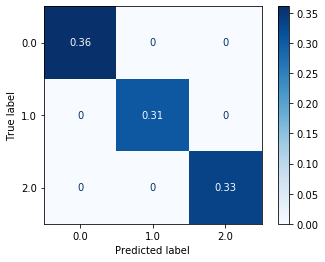

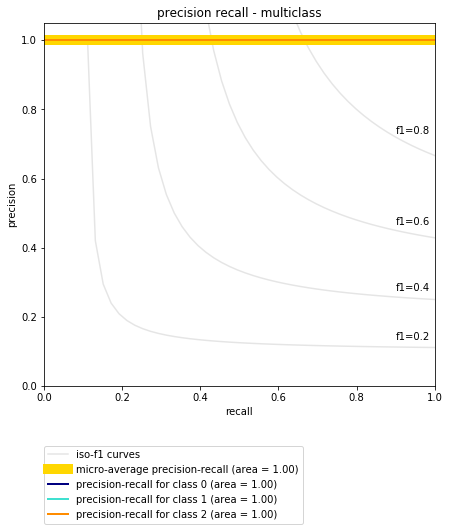

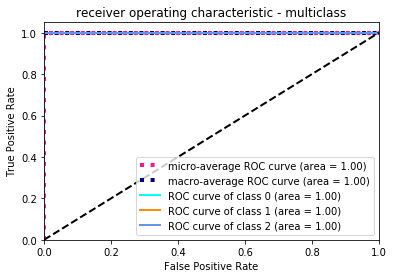

In [11]:
from mlrun import run_local

MODELS = [#"sklearn.ensemble.RandomForestClassifier", 
         #"sklearn.linear_model.LogisticRegression",
         #"sklearn.ensemble.AdaBoostClassifier",
         "xgboost.XGBClassifier"]

for model in MODELS:
    task_params.update({
        "params":{
            "model_pkg_class": model, 
            "model_filename" : model}})
    run = run_local(
        NewTask(**task_params),
        handler=train_model,
        inputs={"dataset"  : mlconf.artifact_path + "/iris.parquet"})

### run remotely

In [12]:
# MODELS = ["sklearn.ensemble.RandomForestClassifier", 
#          "sklearn.linear_model.LogisticRegression",
#          "sklearn.ensemble.AdaBoostClassifier",
#          "lightgbm.LGBMClassifier",
#          "xgboost.XGBClassifier"]
# fn.deploy()
# for model in MODELS:
#     task_params.update({"params":{"model_pkg_class":model, "model_filename" : model}})
#     task = NewTask(**task_params)
#     run = func.run(
#         task,
#         params={"dataset"  : mlconf.artifact_path + "/iris.parquet"},
#         artifact_path=mlconf.artifact_path+"/sklearn_classifier")